In [1]:
# ================================
# 1. Import necessary libraries
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [2]:
from google.colab import files

# Upload the file
uploaded = files.upload()
# Check uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving Weekly Price Latur Soyabean Market.xlsx to Weekly Price Latur Soyabean Market.xlsx
Uploaded file: Weekly Price Latur Soyabean Market.xlsx


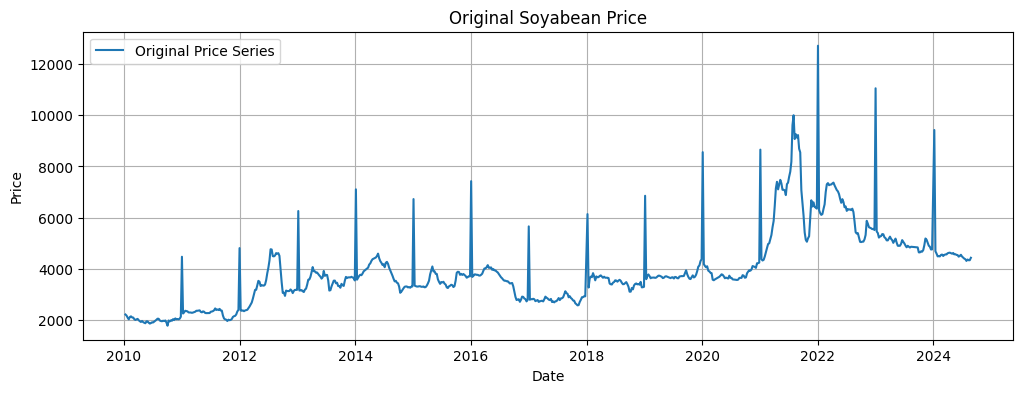

In [3]:
# =====================================
# 2. Load and preprocess the data
# =====================================

file_path = '/content/Weekly Price Latur Soyabean Market.xlsx'
df = pd.read_excel(file_path, parse_dates=['week_ending_date'])
df = df.rename(columns={'week_ending_date': 'Date', 'Latur_Soya': 'Price'})
df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 4))
plt.plot(df['Price'], label='Original Price Series')
plt.title('Original Soyabean Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


In [5]:
# =====================================
# 3. Normalize the Data
# =====================================

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price']])


In [14]:
# =====================================
# 4. Prepare Sequences for ANN
# =====================================
def create_sequences(data, lag=3):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag, 0])
        y.append(data[i+lag, 0])
    return np.array(X), np.array(y)

lag = 3
X_all, y_all = create_sequences(scaled_data, lag=lag)


In [15]:
# =====================================
# 5. Train-Test Split
# =====================================

train_size = int(len(X_all) * 0.90)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train samples: 683, Test samples: 76


In [17]:
# =====================================
# 6. Define ANN Model
# =====================================
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lag,)))
model.add(Dense(1))  # Output layer
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0114
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0121
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0110
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0094
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0094
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

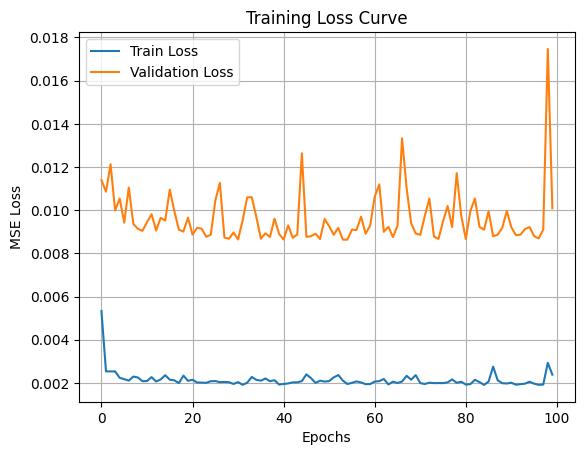

In [18]:
# =====================================
#7. Train the ANN
# =====================================
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# =====================================
# 8. Make Predictions and Invert Scaling
# =====================================

# Predict on both train and test
train_pred_ann = model.predict(X_train)
test_pred_ann = model.predict(X_test)

# Inverse scale
train_pred_ann = scaler.inverse_transform(train_pred_ann)
test_pred_ann = scaler.inverse_transform(test_pred_ann)

y_train_true = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1,1))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [20]:
# =====================================
#  9. Create Index for Predictions
# =====================================
# Shift prediction index for plotting
train_index = df.index[lag:lag+len(train_pred_ann)]
test_index = df.index[lag+len(train_pred_ann):lag+len(train_pred_ann)+len(test_pred_ann)]


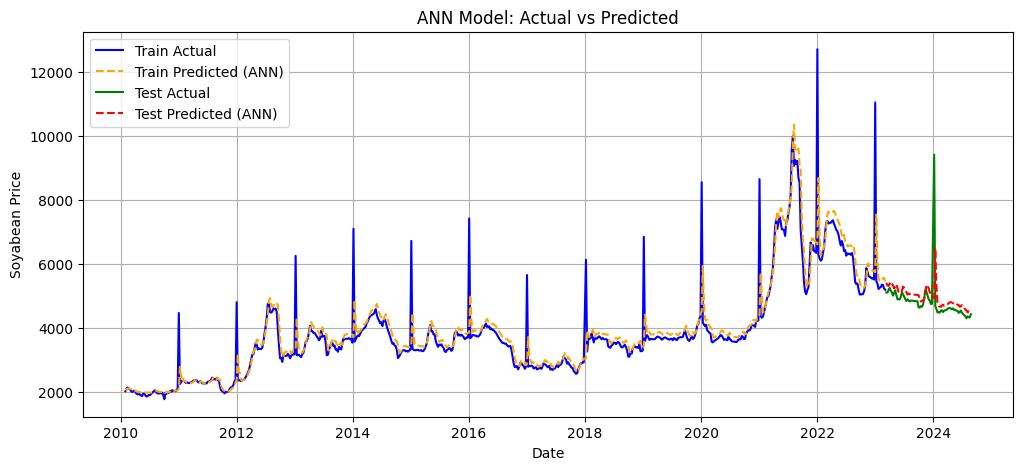

In [21]:
# =====================================
# 10. Plot: ANN Actual vs Predicted
# =====================================
plt.figure(figsize=(12, 5))
plt.plot(train_index, y_train_true, label='Train Actual', color='blue')
plt.plot(train_index, train_pred_ann, label='Train Predicted (ANN)', color='orange', linestyle='--')
plt.plot(test_index, y_test_true, label='Test Actual', color='green')
plt.plot(test_index, test_pred_ann, label='Test Predicted (ANN)', color='red', linestyle='--')
plt.title('ANN Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Soyabean Price')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# =====================================
#  11. Evaluation Metrics (Compare with ARIMA)
# =====================================

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# ANN Metrics
ann_train_rmse = np.sqrt(mean_squared_error(y_train_true, train_pred_ann))
ann_train_mae  = mean_absolute_error(y_train_true, train_pred_ann)
ann_train_mape = mean_absolute_percentage_error(y_train_true, train_pred_ann)

ann_test_rmse = np.sqrt(mean_squared_error(y_test_true, test_pred_ann))
ann_test_mae  = mean_absolute_error(y_test_true, test_pred_ann)
ann_test_mape = mean_absolute_percentage_error(y_test_true, test_pred_ann)

print("\nANN Training Metrics:")
print(f"  RMSE: {ann_train_rmse:.2f}")
print(f"  MAE : {ann_train_mae:.2f}")
print(f"  MAPE: {ann_train_mape:.2f}%")

print("\nANN Testing Metrics:")
print(f"  RMSE: {ann_test_rmse:.2f}")
print(f"  MAE : {ann_test_mae:.2f}")
print(f"  MAPE: {ann_test_mape:.2f}%")



ANN Training Metrics:
  RMSE: 598.74
  MAE : 255.89
  MAPE: 5.66%

ANN Testing Metrics:
  RMSE: 598.05
  MAE : 287.12
  MAPE: 5.44%
